# **Projet de régression : NYC taxis tips**

## **Descriptive analysis**

Les données correspondent à des courses en taxi effectuées au mois de Janvier 2024

#### **Format des données**

Les données sont fournis au format parquet. Pour lire les fichiers parquets, utiliser la fonction `read_parquet` de `pandas`. Cela nécessite l'installation au préalable de la librarie pyarrow (`pip install pyarrow`) ou bien fastparquet (`pip install fastparquet`) si ce n'est pas déjà fait.

#### **Fichiers**

* **train.parquet** - le jeu de données d'entraînement (incluant la variable à prédire *tip_amount*)

* **test.parquet** - le jeu de données test (sans la variable à prédire *tip_amount*)

* **naive_submission.parquet** - un exemple de solution (prédiction naive)

In [254]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from meteostat import Point as Pt
from meteostat import Daily
import geopandas as gpd
from shapely.geometry import Point

#### **Utils**

In [253]:
def haversine_distance(lat1, lon1, lat2, lon2):
     R = 6371 # Earth radius in kilometers

     phi1, phi2 = np.radians(lat1), np.radians(lat2)
     dphi = np.radians(lat2 - lat1)
     dlambda = np.radians(lon2 - lon1)
     a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
     
     return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

##### **Load the Dataset**

In [255]:
#### Structure of the data set
train_data = pd.read_parquet(path = "Data/train_1.parquet")
test_data = pd.read_parquet(path = "Data/test_1.parquet")


In [197]:
train_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
0,1,2024-01-15 20:37:28,2024-01-15 20:56:43,1.0,3.30,1.0,N,1,19.1,3.5,0.5,4.80,0.0,1.0,2.5,0.0,40.734576,-74.002875,40.768615,-73.965635
1,2,2024-01-25 19:41:24,2024-01-25 19:44:42,1.0,0.72,1.0,N,1,5.8,2.5,0.5,2.46,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.780436,-73.957012
2,2,2024-01-25 15:48:48,2024-01-25 16:24:23,2.0,7.45,1.0,N,1,38.7,0.0,0.5,3.00,0.0,1.0,2.5,0.0,40.717773,-74.007880,40.780436,-73.957012
3,2,2024-01-27 00:47:26,2024-01-27 00:55:55,1.0,1.53,1.0,N,1,10.0,1.0,0.5,2.25,0.0,1.0,2.5,0.0,40.720889,-73.996919,40.747746,-73.978492
4,2,2024-01-28 13:14:26,2024-01-28 13:22:34,1.0,1.53,1.0,N,1,10.0,0.0,0.5,3.50,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.747746,-73.978492


In [198]:
train_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon'],
      dtype='object')

##### **Feature Enginneering Pipeline**

Feature Enginneering is a very imporant task in this type of problems

#### **Time features**

In [252]:
## Time feature Engineering Pipline

def add_time_features(df):
     # Convert datetime columns
     df["pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
     df["dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

     # Duration in minutes
     df["duration"] = (df["dropoff_datetime"] - df["pickup_datetime"]).dt.total_seconds() / 60
     
     # Date-based features
     df["pickup_hour"] = df["pickup_datetime"].dt.hour
     df["pickup_day"] = df["pickup_datetime"].dt.day
     df["pickup_weekday"] = df["pickup_datetime"].dt.weekday
     df["is_night"] = 0 <= df["pickup_datetime"].dt.hour <7
     df["is_weekend"] = df["pickup_datetime"].dt.weekday >= 5

     df = df.drop(columns=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
     return df

##### **Spatial Features**

In [200]:
def add_distance_features(df):
     df["trip_distance"] = haversine_distance(df["PU_location_lat"], df["PU_location_lon"], 
                                              df["DO_location_lat"], df["DO_location_lon"])
     return df

* **Add Airport Proximity Features** : Include features to indicate whether a pickup of drop-off is close to one of NYC's main airports (JFK, LaGuardia, Newark). These proximity indicators can be binary features based on latitude and longitude comparaisons, as shown below

In [251]:
def airport_proximity(df):
    # JFK
    
    Is_JFK = ((df['PU_location_lat'].between(40.63, 40.65)) & 
                    (df['PU_location_lon'].between(-73.79, -73.77))) | \
                   ((df['DO_location_lat'].between(40.63, 40.65)) & 
                    (df['DO_location_lon'].between(-73.79, -73.77)))
    
    # LaGuardia
    
    Is_laguardia = ((df['PU_location_lat'].between(40.77, 40.78)) & 
                          (df['PU_location_lon'].between(-73.88, -73.87))) | \
                         ((df['DO_location_lat'].between(40.77, 40.78)) & 
                          (df['DO_location_lon'].between(-73.88, -73.87)))
    
    # Newark
    
    Is_newark = ((df['PU_location_lat'].between(40.68, 40.69)) & 
                       (df['PU_location_lon'].between(-74.18, -74.17))) | \
                      ((df['DO_location_lat'].between(40.68, 40.69)) & 
                       (df['DO_location_lon'].between(-74.18, -74.17)))
    
    df["Is_Airport"] = Is_JFK | Is_laguardia | Is_newark
    return df

* **Distance to Key Landmarks** : The idea is to calculate the distance from each pickup and drop-off location to major NYC landmarks, such as Times Square, Central Park, ... This could help capture tourism or business-related trips, which might correlate with different tipping behaviors.

In [250]:
def distance_to_Key_Landmarks(df):

    ## A dictionnary containing the most iconic landmarks in New York City

    nyc_landmarks = {
    "Liberty": [40.6892, -74.0445],
    "Empire": [40.748817, -73.985428],
    "CentralPark": [40.785091, -73.968285],
    "TimesSquare": [40.758896, -73.985130],
    "BrooklynBridge": [40.706086, -73.996864],
    "OneWorld": [40.712743, -74.013379],
    "Rockefeller": [40.758740, -73.978674],
    "Broadway": [40.759011, -73.984472],
    "MetMuseum": [40.779437, -73.963244],
    "FifthAve": [40.774210, -73.965310],
    "GrandCentral": [40.752726, -73.977229],
    "HighLine": [40.747993, -74.004765],
    "WallStreet": [40.707491, -74.011276],
    "Chrysler": [40.751652, -73.975311],
    "StatenFerry": [40.701301, -74.013120]
    }

    ## Compute the haversine distances between Pickup and Dropoff locations
    min_distances = []
    for i in len(df):
        distances = [
            haversine_distance(df["PU_location_lat"].iloc[i], df["PU_location_lon"].iloc[i],\
                                                       coord[0], coord[1]) for coord in nyc_landmarks.values()
        ]

        min_distances.append(min(distances))

    df["distance_to_Key_Landmark"] = min_distances
    return(df)

* **Borough Clustering** : The idea here is to use the official Taxi and Limousine Comission (TLC) zones. And map each pickup and drop-off location to its corresponding zone and borough (Manhattan, Brooklyn, ...). Each zone has a unique ID.

In [249]:
def add_neighborhood(df):
    gdf = gpd.read_file("Data/NYC Taxi Zones.geojson")
    df["geometry"] = [Point(xy) for xy in zip(df["PU_location_lon"], df["PU_location_lat"])]
    df = gpd.GeoDataFrame(df, geometry="geometry"); df.crs = "EPSG:4326"
    df = gpd.sjoin(df, gdf, how = "left", predicate = "within")
    df = df.drop(columns = ["geometry", "index_right", "shape_area", "objectid", "shape_area", "objectid", "shape_leng", "location_id"])
    return df

##### **Creating the feature enginnering pipeline**

In [ ]:
def filter_data(df):
     # Filter data by payment type (keep credit card payments only)
     df = df[df["payment_type"] == 1]

     return(df)

def Drop_useless(df, col_list = ["payment_type", "pickup_datetime", "dropoff_datetime", "zone"]):
     return df.drop(columns = col_list)

def Categorical_data(df, type = None):
     cat_data = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'borough']
     if (type == 'String'):
          for var in cat_data:
               df[var] = df[var].astype('category').astype(str).fillna('missing')
          return df      
     elif (type == 'Int'):
          for var in cat_data:
               df[var] = df[var].astype('category').cat.codes.astype('int32')
          return df
     return pd.get_dummies(df, columns = cat_data, drop_first = True)

# Pipeline for feature engineering 

base_pipeline = Pipeline([
     ('copy', FunctionTransformer(lambda df : df.copy())),   ## Avoid applying changes on the dataset passed in argument
     
     # Time features
     ("add_time_features", FunctionTransformer(add_time_features)),

     # Spatial features
     ("add_distance_features", FunctionTransformer(add_distance_features)),
     ("airport_proximity", FunctionTransformer(airport_proximity)),
     ("distance_to_Key_Landmarks", FunctionTransformer(distance_to_Key_Landmarks)),
     ("add_neighborhood", FunctionTransformer(add_neighborhood))
])

In [256]:
import copy
pipeline = copy.deepcopy(base_pipeline)
pipeline.steps.extend([('Categorical_data', FunctionTransformer(Categorical_data)),
                          ('Drop_useless', FunctionTransformer(lambda df: Drop_useless(df, ['pickup_datetime', 'dropoff_datetime', 'zone'])))])
train_data_fe = pipeline.fit_transform(train_data)

#### **Apercu général et valeurs manquantes**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               100000 non-null  int32         
 1   tpep_pickup_datetime   100000 non-null  datetime64[us]
 2   tpep_dropoff_datetime  100000 non-null  datetime64[us]
 3   passenger_count        100000 non-null  float64       
 4   trip_distance          100000 non-null  float64       
 5   RatecodeID             100000 non-null  float64       
 6   store_and_fwd_flag     100000 non-null  object        
 7   payment_type           100000 non-null  int64         
 8   fare_amount            100000 non-null  float64       
 9   extra                  100000 non-null  float64       
 10  mta_tax                100000 non-null  float64       
 11  tip_amount             100000 non-null  float64       
 12  tolls_amount           100000 non-null  float

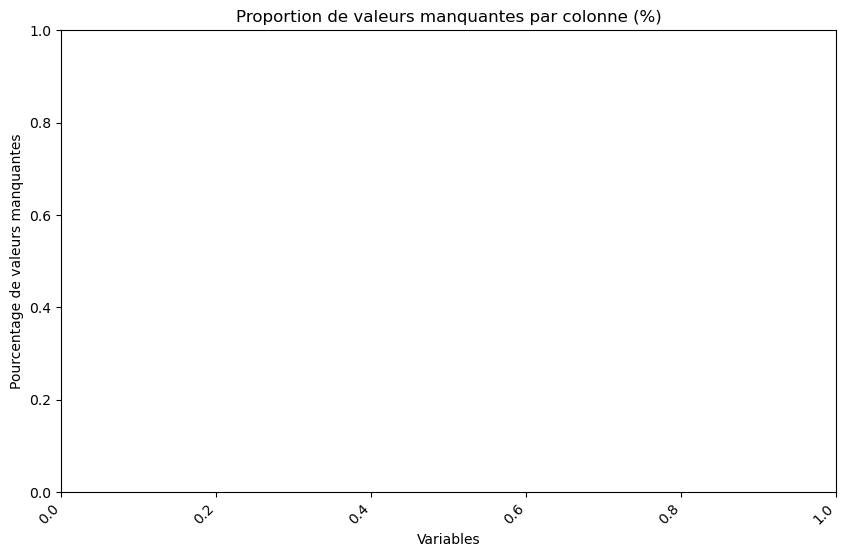

In [208]:
train_data.info()

## Affichage des valeurs manquantes

missing_values = train_data.isnull().sum()/len(train_data) *100
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)
missing_values

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.title("Proportion de valeurs manquantes par colonne (%)")
plt.xlabel("Variables")
plt.ylabel("Pourcentage de valeurs manquantes")
plt.show()

la base ne contient aucune valeurs manquante

#### **Analyse Graphique**

##### **1 . Gategorical variables**

We show basic bar plot for the categorical variables :

* `VendorID`


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



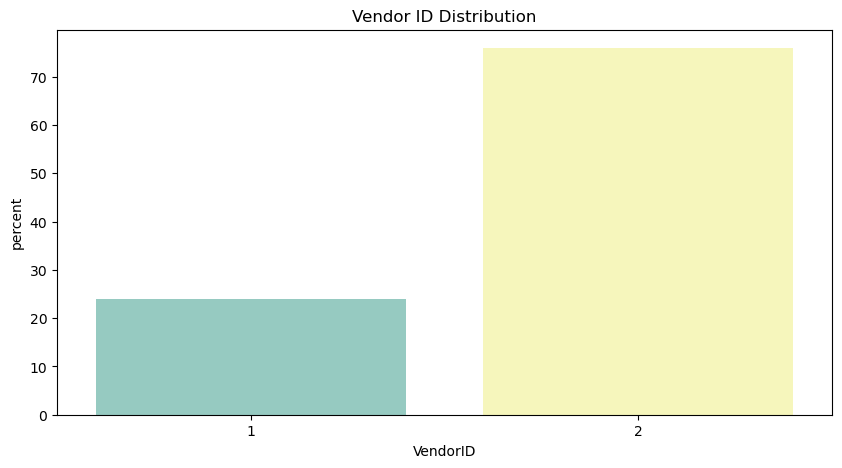

In [209]:
plt.figure(figsize=(10, 5))
sns.countplot(x="VendorID", data=train_data, palette="Set3", stat='percent')
plt.title("Vendor ID Distribution")
plt.show()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



(0.0, 20.0)

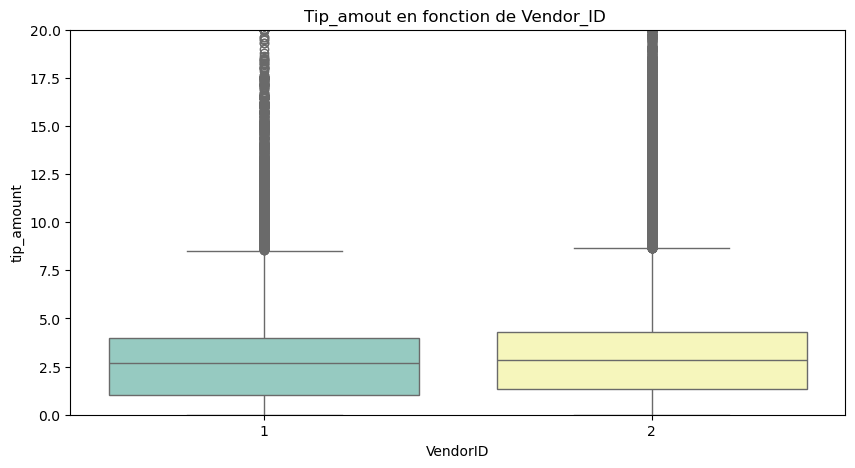

In [210]:
plt.figure(figsize=(10,5))
sns.boxplot(x = "VendorID", y = "tip_amount", data = train_data, palette = "Set3")
plt.title("Tip_amout en fonction de Vendor_ID ")
plt.ylim((0,20))


* **Payment type**


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Text(0.5, 1.0, 'Payement type')

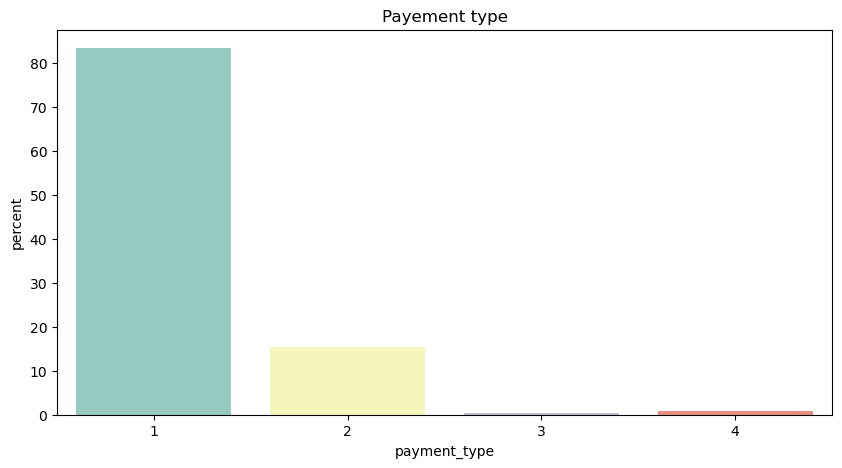

In [211]:
plt.figure(figsize = (10, 5))
sns.countplot(x = "payment_type", data = train_data, palette = "Set3", stat = 'percent')
plt.title("Payement type")


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



(0.0, 20.0)

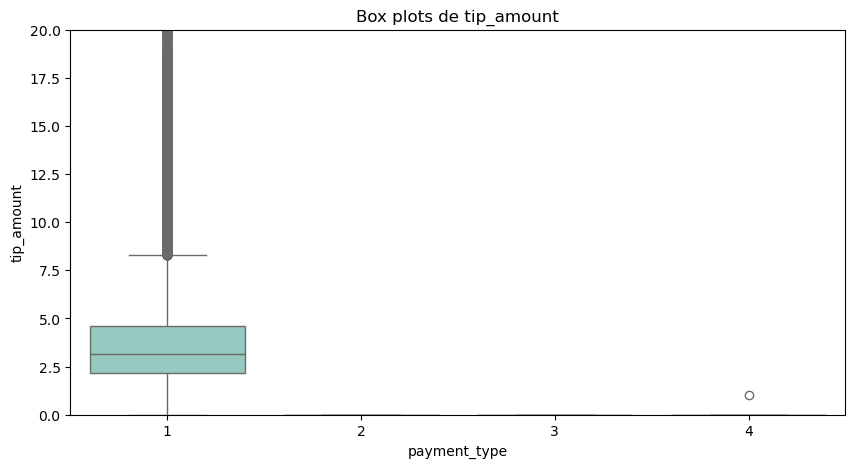

In [212]:
plt.figure(figsize=(10,5))
sns.boxplot(x = "payment_type", y = "tip_amount", data = train_data, palette = 'Set3')
plt.title("Box plots de tip_amount")
plt.ylim((0,20))
#plt.ylim((0,2.5))


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



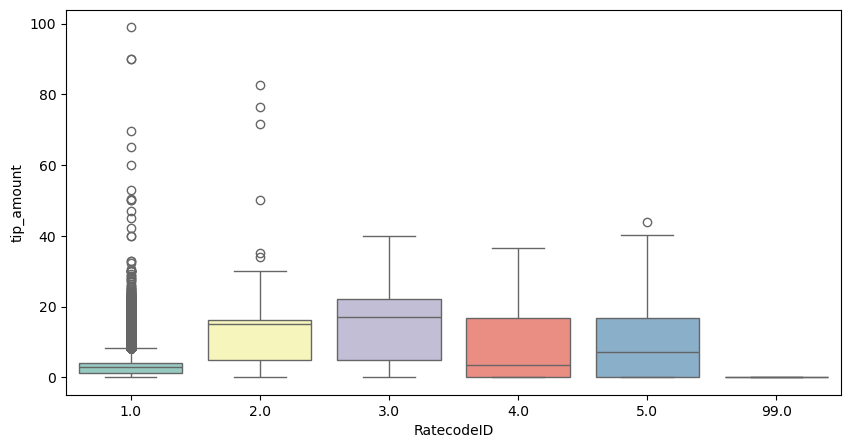


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



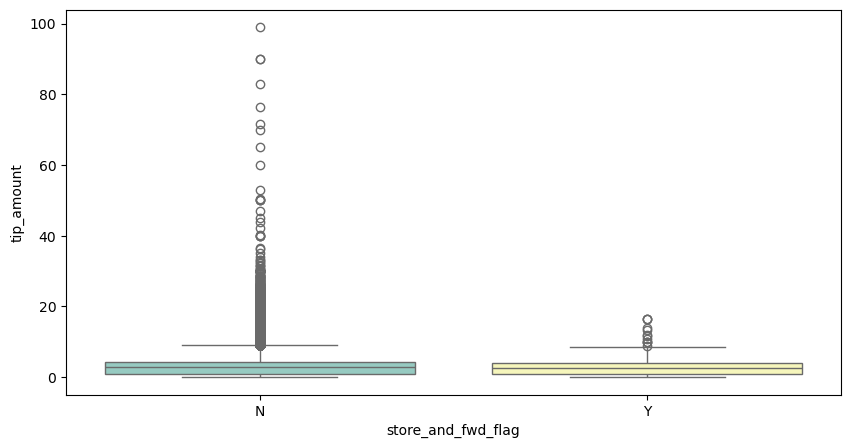

In [213]:
plt.figure(figsize=(10,5))
sns.boxplot(x = "RatecodeID", y = "tip_amount", data = train_data, palette = 'Set3')
plt.show()

plt.figure(figsize = (10,5))
sns.boxplot(x = "store_and_fwd_flag", y = "tip_amount", data = train_data, palette = 'Set3')
plt.show()

* For payment types "Cash" and "No charge" the tip amount is always zero, for "Dispute" is always zero except for one observation
* For "Cash" payments the amount of tip is a truncated information
* For "Dispute" usualy if someone had a dispute with the taxi driver (logically) he would'nt give him tips for the trip

more than 80% of the payments were using a credit card, in a firt time we will use only the data coming from credit card payments
and we suppose that tip_amount is always zero for other payment types

### **Analyse des variables quantitatives**

On se restreint aux observations dont le paiement est réalisé par carte bancaire

In [214]:
train_data = train_data[train_data["payment_type"] == 1]

##### **Analyse de la distribution de la variable cible**

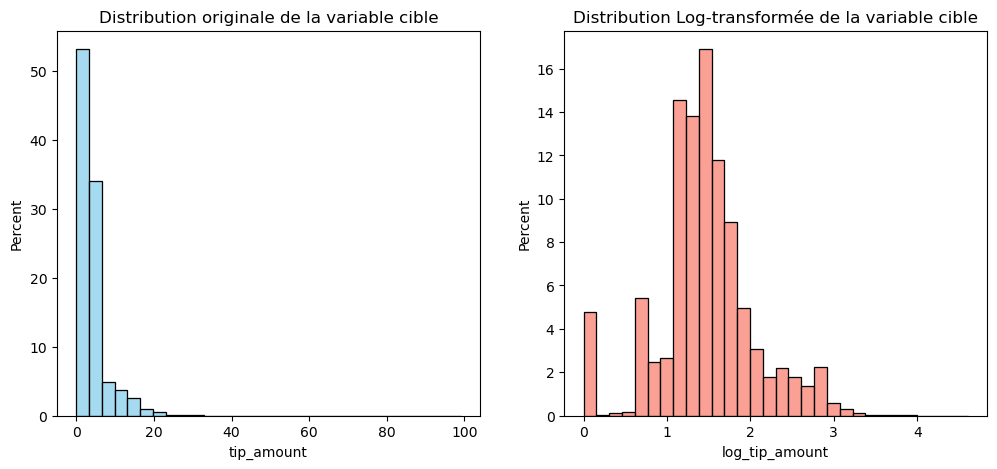

In [215]:

# Log transformation for skewness reduction
train_data['log_tip_amount'] = np.log1p(train_data['tip_amount'])
# Plot original and log-transformed distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(train_data['tip_amount'], bins=30, ax=axes[0], color='skyblue', stat = 'percent')
axes[0].set_title("Distribution originale de la variable cible")

sns.histplot(train_data['log_tip_amount'], bins=30, ax=axes[1], color='salmon', stat = 'percent')
axes[1].set_title("Distribution Log-transformée de la variable cible")
plt.show()

#### **Analyse des valeurs extrêmes**

On trace les boxplots des deux distributions : originale et log-transformed

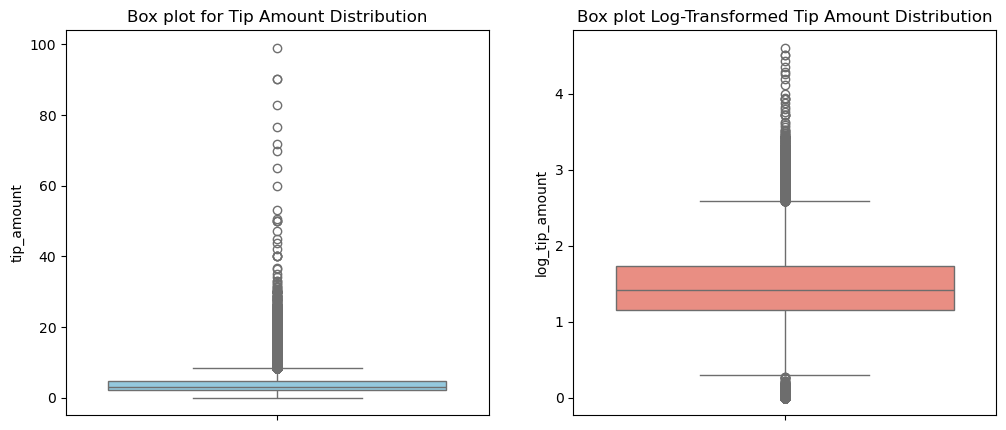

In [216]:
# Log transformation for skewness reduction
train_data['log_tip_amount'] = np.log1p(train_data['tip_amount'])
# Plot original and log-transformed distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(train_data['tip_amount'], ax=axes[0], color='skyblue')
axes[0].set_title("Box plot for Tip Amount Distribution")

sns.boxplot(train_data['log_tip_amount'], ax=axes[1], color='salmon')
axes[1].set_title("Box plot Log-Transformed Tip Amount Distribution")
plt.show()

#### **Analyse des caractéristiques temporelles**

On travaille avec la base `train_data_fe` à laquelle nous avons appliqué des transformations temporelles. Nous présentons Heatmap des montants moyens des pouboires par heure et jour de la semaine.

* **Jour de la semaine**

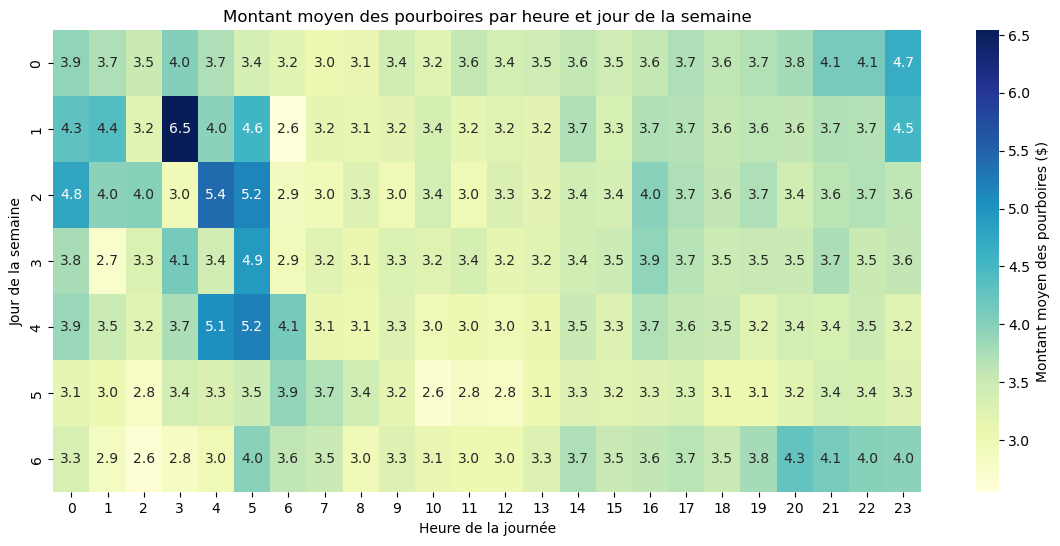

In [217]:
pivot_table = train_data_fe.pivot_table(values='tip_amount', index='pickup_weekday', columns='pickup_hour', aggfunc='mean')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={'label': 'Montant moyen des pourboires ($)'})
plt.title("Montant moyen des pourboires par heure et jour de la semaine")
plt.xlabel("Heure de la journée")
plt.ylabel("Jour de la semaine")
plt.show()

* **Jour du mois**

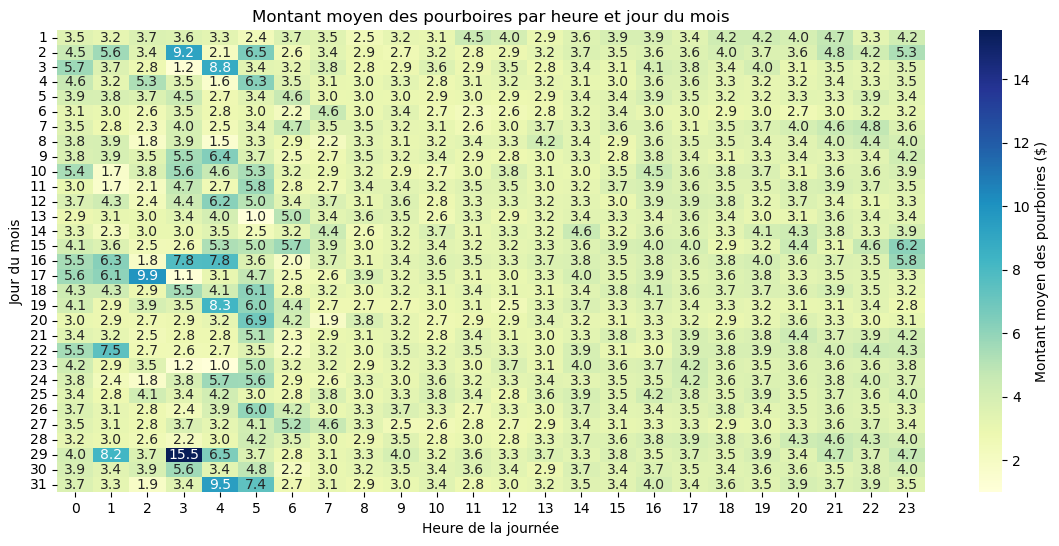

In [218]:
pivot_table = train_data_fe.pivot_table(values='tip_amount', index='pickup_day', columns='pickup_hour', aggfunc='mean')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={'label': 'Montant moyen des pourboires ($)'})
plt.title("Montant moyen des pourboires par heure et jour du mois")
plt.xlabel("Heure de la journée")
plt.ylabel("Jour du mois")
plt.show()

##### **Analyse géospatiale**

* **Distribution des pourboires en fonction des lieux de prise en charge** : L'analyse géospatiale révèle des tendances selon les emplacements des prises en charge et des déposes.

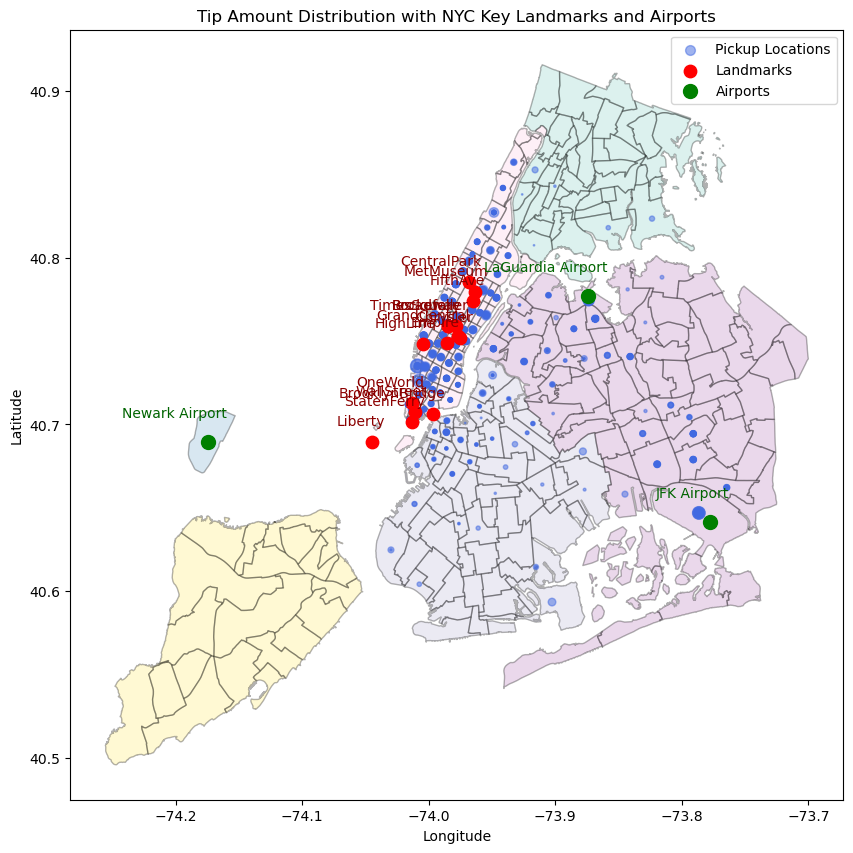

In [233]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Define NYC landmarks and airport locations
nyc_landmarks = {
    "Liberty": [40.6892, -74.0445],
    "Empire": [40.748817, -73.985428],
    "CentralPark": [40.785091, -73.968285],
    "TimesSquare": [40.758896, -73.985130],
    "BrooklynBridge": [40.706086, -73.996864],
    "OneWorld": [40.712743, -74.013379],
    "Rockefeller": [40.758740, -73.978674],
    "Broadway": [40.759011, -73.984472],
    "MetMuseum": [40.779437, -73.963244],
    "FifthAve": [40.774210, -73.965310],
    "GrandCentral": [40.752726, -73.977229],
    "HighLine": [40.747993, -74.004765],
    "WallStreet": [40.707491, -74.011276],
    "Chrysler": [40.751652, -73.975311],
    "StatenFerry": [40.701301, -74.013120]
}

airports = {
    "JFK Airport": [40.6413, -73.7781],
    "LaGuardia Airport": [40.7769, -73.8740],
    "Newark Airport": [40.6895, -74.1745]
}

# Convert landmarks and airports into GeoDataFrames for easy plotting
landmark_points = gpd.GeoDataFrame({
    "name": list(nyc_landmarks.keys()),
    "geometry": [Point(lon, lat) for lat, lon in nyc_landmarks.values()]
}, crs="EPSG:4326")

airport_points = gpd.GeoDataFrame({
    "name": list(airports.keys()),
    "geometry": [Point(lon, lat) for lat, lon in airports.values()]
}, crs="EPSG:4326")

# Load NYC zones and merge with taxi data
nyc_zones = gpd.read_file("Data/NYC Taxi Zones.geojson")  # Replace with the actual path
taxi_data_gdf = gpd.GeoDataFrame(train_data, geometry=gpd.points_from_xy(train_data.PU_location_lon, train_data.PU_location_lat), crs="EPSG:4326")
taxi_data_gdf = gpd.sjoin(taxi_data_gdf, nyc_zones, how="left", predicate="within")

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot NYC zones by borough with transparency for readability
nyc_zones.plot(ax=ax, column="borough", cmap="Set3", legend=True, edgecolor="black", alpha=0.3)
taxi_data_gdf.plot(ax=ax, markersize=taxi_data_gdf["tip_amount"], alpha=0.5, color="royalblue", label="Pickup Locations")

# Plot landmarks in red and airports in green
landmark_points.plot(ax=ax, color="red", markersize=80, label="Landmarks")
airport_points.plot(ax=ax, color="green", markersize=100, label="Airports")

# Label landmarks and airports with slight offsets
for idx, row in landmark_points.iterrows():
    x_offset, y_offset = 0.01, 0.01
    plt.text(row.geometry.x + x_offset, row.geometry.y + y_offset, row["name"],
             fontsize=10, ha="right", color="darkred")

for idx, row in airport_points.iterrows():
    x_offset, y_offset = 0.015, 0.015
    plt.text(row.geometry.x + x_offset, row.geometry.y + y_offset, row["name"],
             fontsize=10, ha="right", color="darkgreen")

# Add plot styling
plt.legend(loc="upper right")
plt.title("Tip Amount Distribution with NYC Key Landmarks and Airports")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


##### **Analyse des correlations entre les variables explicatives**

##### **Grande matrice de corrélation**

Matrice de correlation avec toutes les variables

In [245]:
train_data_fe.columns.is_floating

columns_selection = ['tip_amount','passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
        'tolls_amount', 'improvement_surcharge',
       'congestion_surcharge', 'Airport_fee', 'PU_location_lat',
       'PU_location_lon', 'DO_location_lat', 'DO_location_lon', 'duration',
       'pickup_hour', 'pickup_day', 'pickup_weekday']

<Axes: >

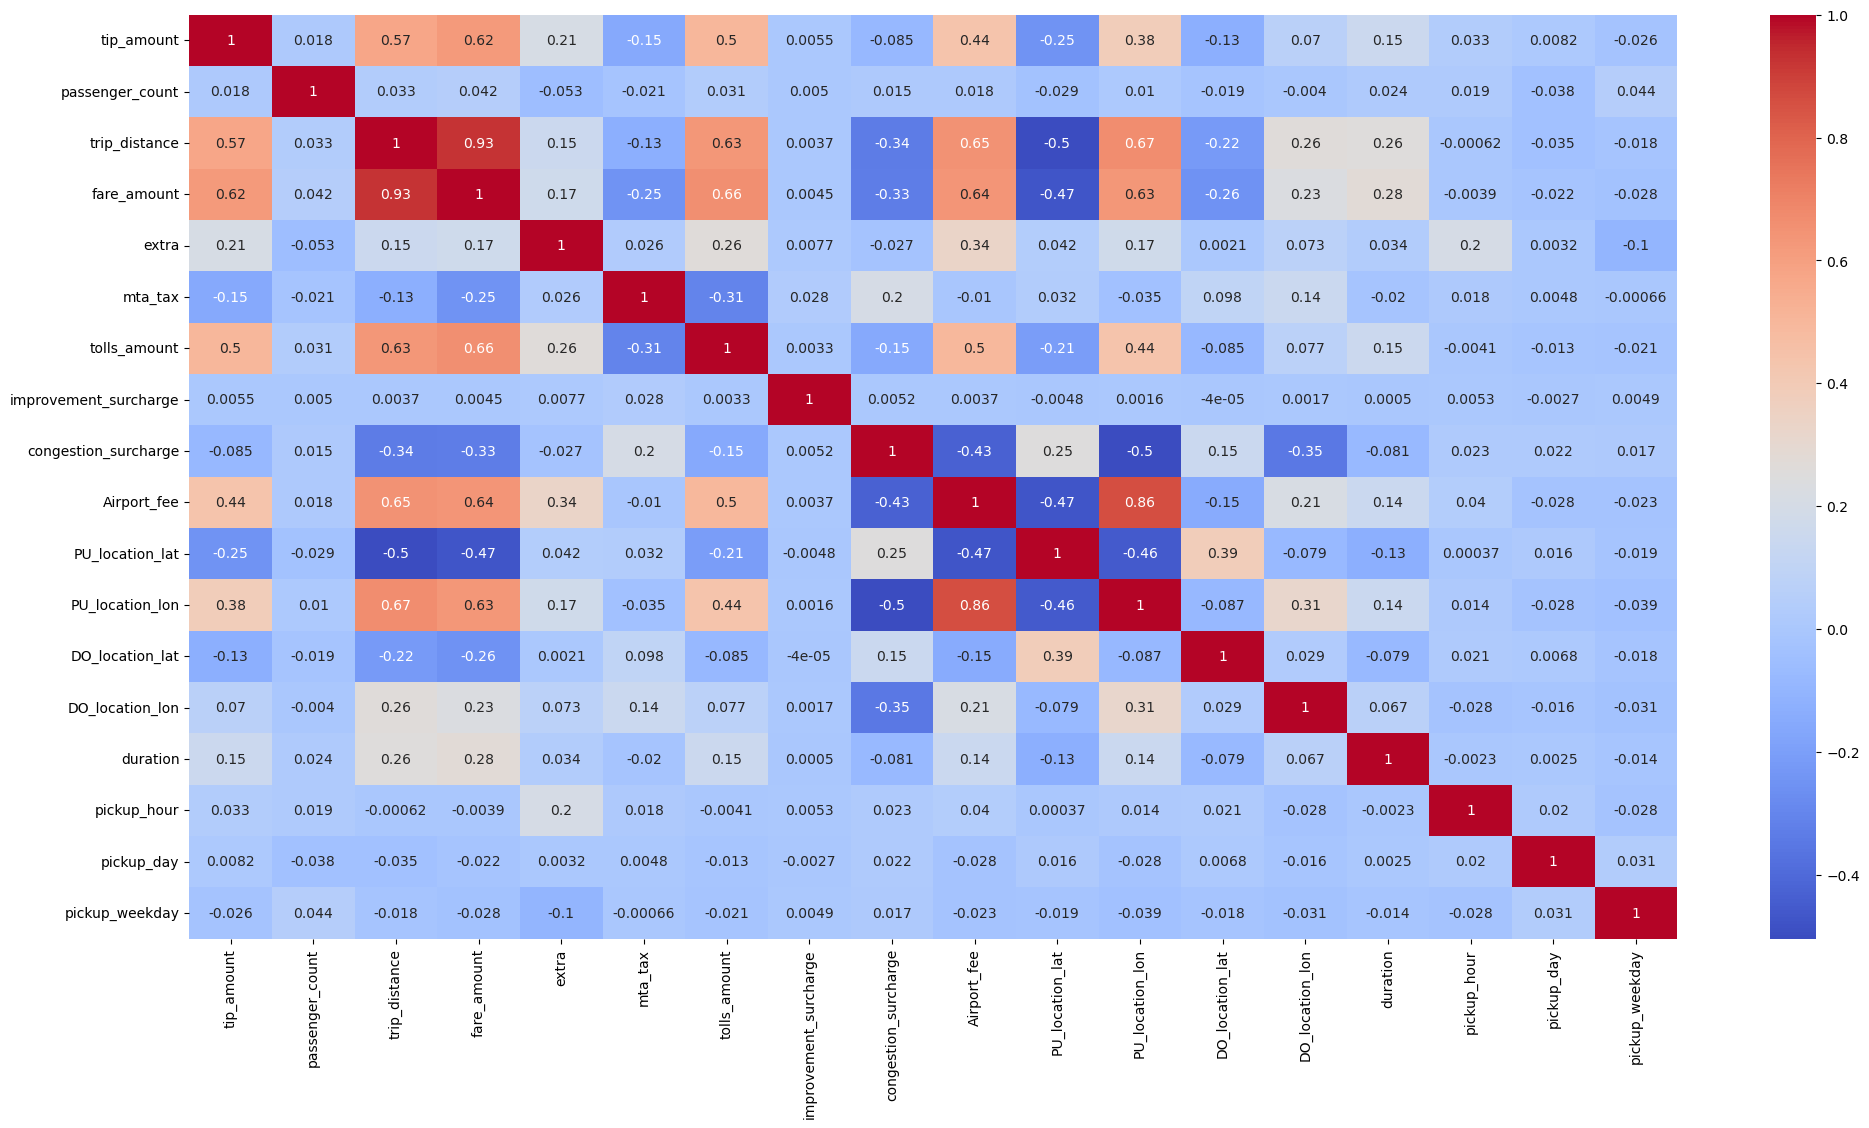

In [246]:
plt.figure(figsize=(24,12))
sns.heatmap(train_data_fe[columns_selection].corr(), annot = True, cmap = 'coolwarm')

#### **Matrice de corrélation réduite**

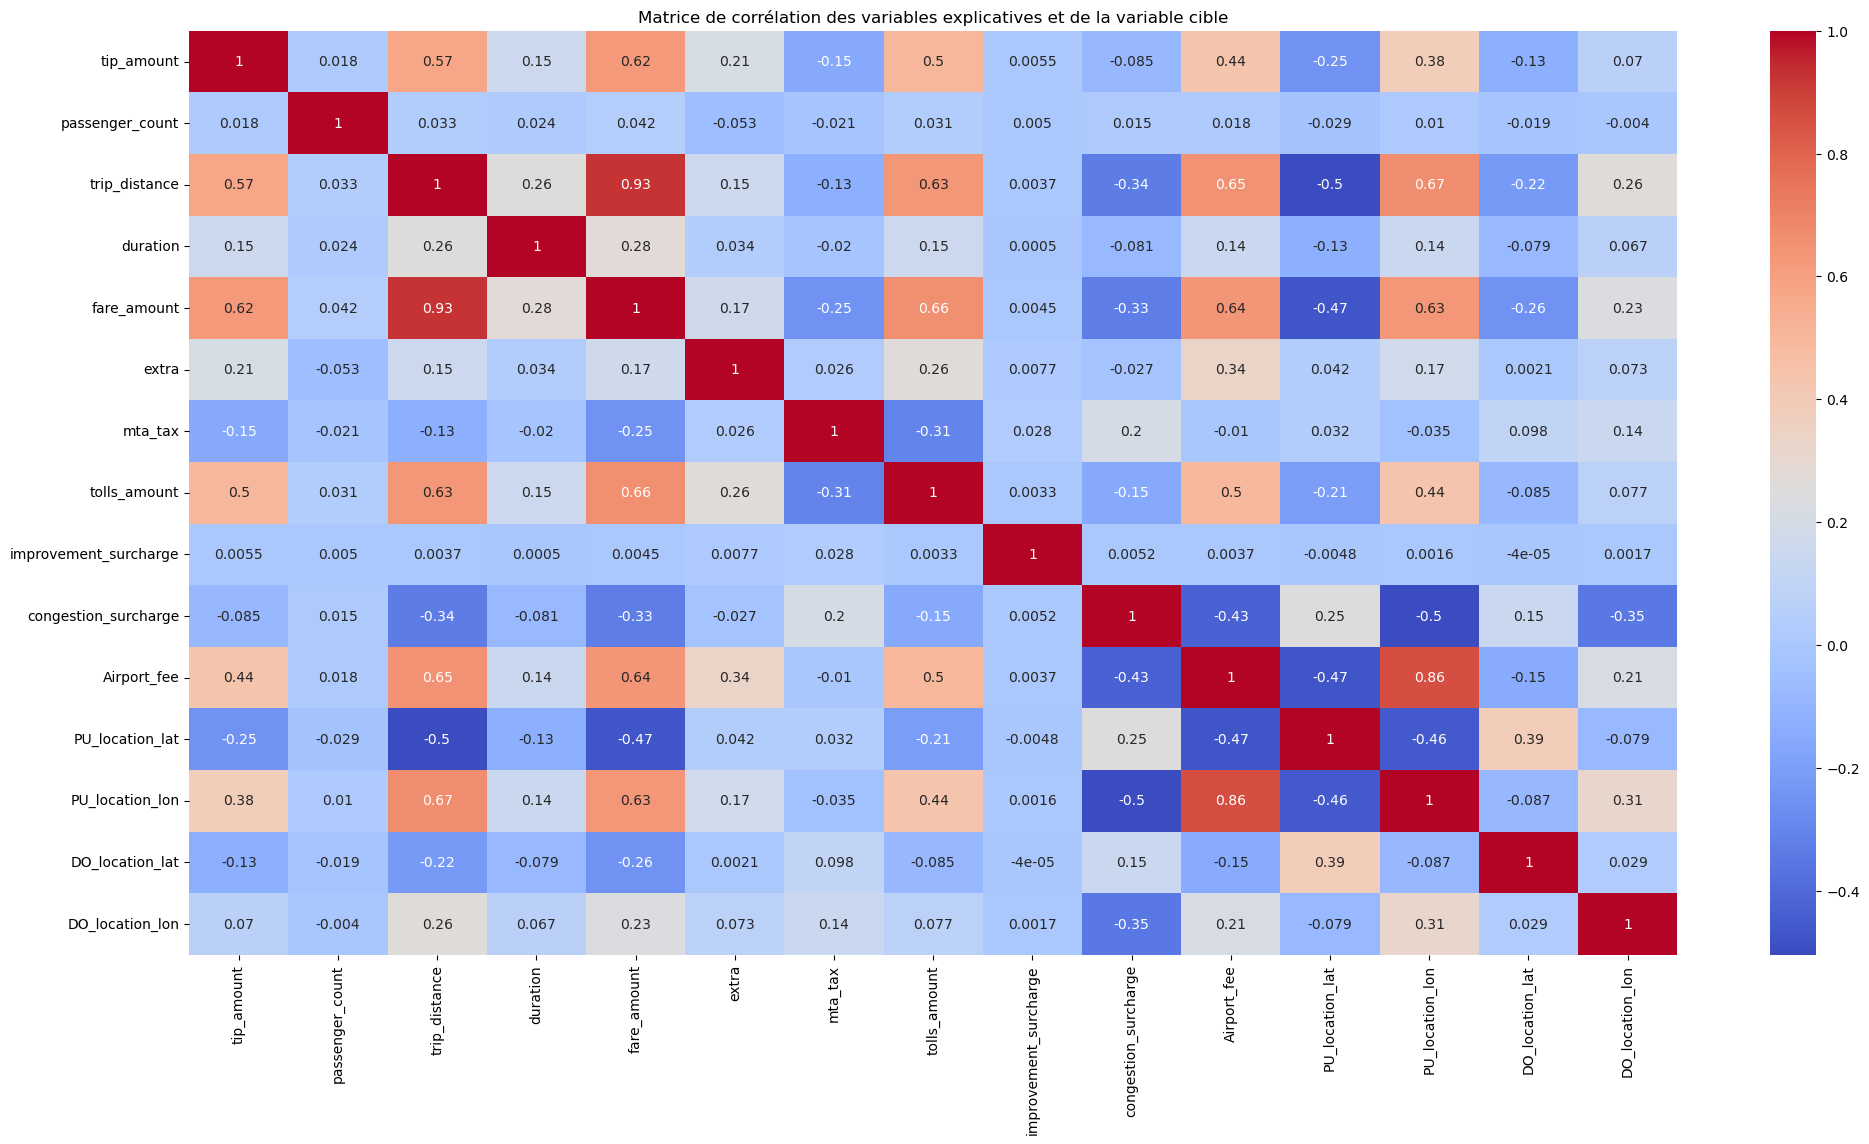

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grande matrice de corrélation pour les variables principales
plt.figure(figsize=(24, 12))
sns.heatmap(train_data_fe[[
    "tip_amount", "passenger_count", "trip_distance", "duration", "fare_amount", "extra", "mta_tax", 
    "tolls_amount", "improvement_surcharge", "congestion_surcharge", "Airport_fee", "PU_location_lat", 
    "PU_location_lon", "DO_location_lat", "DO_location_lon"
]].corr(), annot=True, cmap='coolwarm')

plt.title("Matrice de corrélation des variables explicatives et de la variable cible")
plt.show()


#### **Performing a PCA with the selected variables**

In [ ]:
## Packages for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Run a PCA
train_data_PCA = train_data[["duration","trip_distance", "fare_amount", "extra", "mta_tax", "tolls_amount", "congestion_surcharge", "Airport_fee", "PU_location_lat", "PU_location_lon", "DO_location_lat", "DO_location_lon"]]
train_data_PCA.info()

## Standardize the data
scaler = StandardScaler()
scaled_train_data_PCA = scaler.fit_transform(train_data_PCA)

## Fit PCA
pca = PCA(n_components = 4)
pca.fit(scaled_train_data_PCA)
pca_data = pca.transform(scaled_train_data_PCA)

<class 'pandas.core.frame.DataFrame'>
Index: 82438 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   duration              82438 non-null  float64
 1   trip_distance         82438 non-null  float64
 2   fare_amount           82438 non-null  float64
 3   extra                 82438 non-null  float64
 4   mta_tax               82438 non-null  float64
 5   tolls_amount          82438 non-null  float64
 6   congestion_surcharge  82438 non-null  float64
 7   Airport_fee           82438 non-null  float64
 8   PU_location_lat       82438 non-null  float64
 9   PU_location_lon       82438 non-null  float64
 10  DO_location_lat       82438 non-null  float64
 11  DO_location_lon       82438 non-null  float64
dtypes: float64(12)
memory usage: 8.2 MB


In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(explained_variance)
print(cumulative_variance)

[0.38270188 0.11756101 0.09818436 0.08830475]
[0.38270188 0.50026289 0.59844725 0.686752  ]


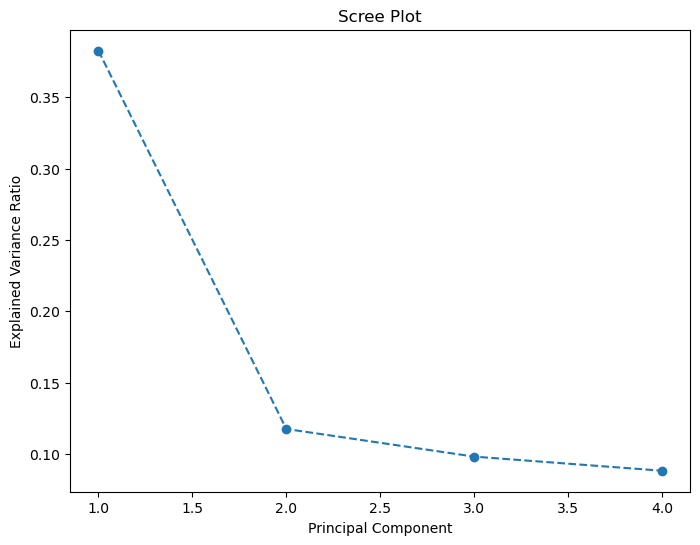

In [ ]:
## Scree plot

# Scree plot
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()


In [ ]:
# Project the original data onto the first 2 principal components
pca_df = pd.DataFrame(pca_data[:, :4], columns=['PC1', 'PC2','PC3','PC4'])
print(pca_df.head())
pca_df["NonZero"] = train_data["NonZero"]
pca_df["RatecodeID"] = train_data["RatecodeID"]

        PC1       PC2       PC3       PC4
0 -0.214722 -0.347125  0.121043  0.589511
1 -0.996580 -1.113268  0.491419 -0.150974
2  0.635040  0.284173 -0.712748  0.111337
3 -0.668491  0.663940 -0.745381 -0.045550
4 -0.908264  0.267532 -0.253180 -0.348333
